<a href="https://colab.research.google.com/github/Anisafi/uas_datmin/blob/main/SVM_DM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Hubungkan Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 2. Import Library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_curve, auc,
    precision_recall_curve, log_loss
)

In [8]:
# 3. Load Dataset
df = pd.read_csv('/content/drive/MyDrive/DM/winequality-red.csv', sep=';')  # Ubah path jika berbeda

In [9]:
# 4. Preprocessing
# Remove quotes from column names
df.columns = df.columns.str.replace('"', '')

df = df.drop(['fixed acidity', 'free sulfur dioxide'], axis=1)

X = df.iloc[:, :-1]
y = df['quality']

# Konversi jadi biner: 0 = Bad (<=6), 1 = Good (>6)
y = y.apply(lambda x: 1 if x > 6 else 0)

In [10]:
# 5. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
# 6. Training SVM (dengan Kalibrasi untuk Probabilitas)
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
calibrated_svm = CalibratedClassifierCV(svm_model, cv=5)

start_time = time.time()
calibrated_svm.fit(X_train, y_train)
training_time = time.time() - start_time


In [12]:
# 7. Evaluasi
y_pred = calibrated_svm.predict(X_test)
y_prob = calibrated_svm.predict_proba(X_test)[:, 1]

acc_train = calibrated_svm.score(X_train, y_train)
acc_test = accuracy_score(y_test, y_pred)

print("Akurasi Training :", round(acc_train * 100, 2), "%")
print("Akurasi Testing  :", round(acc_test * 100, 2), "%")
print(f"Waktu Training   : {training_time:.4f} detik")

Akurasi Training : 86.71 %
Akurasi Testing  : 85.62 %
Waktu Training   : 0.8604 detik


In [13]:
# 8. Cross Validation
cv_scores = cross_val_score(calibrated_svm, X_train, y_train, cv=5)
print("Cross Validation Akurasi (mean):", round(cv_scores.mean() * 100, 2), "%")


Cross Validation Akurasi (mean): 86.32 %


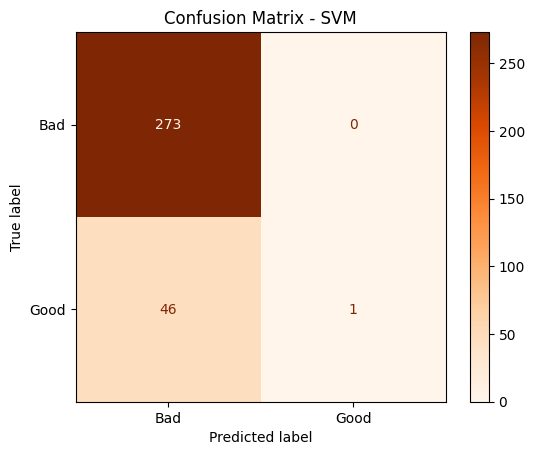

In [14]:
# 9. Confusion Matrix
ConfusionMatrixDisplay.from_estimator(calibrated_svm, X_test, y_test, display_labels=["Bad", "Good"], cmap='Oranges')
plt.title("Confusion Matrix - SVM")
plt.show()

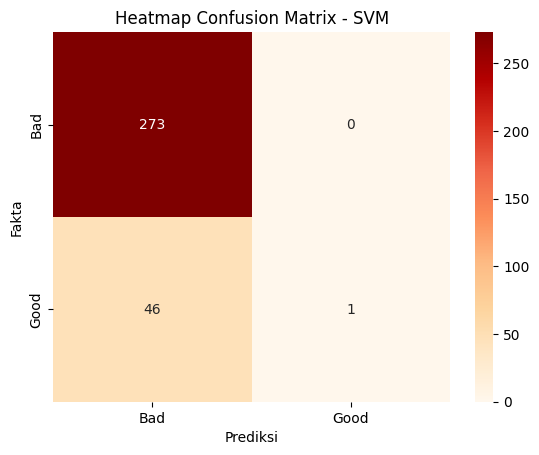

In [15]:
# 10. Heatmap Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='OrRd', xticklabels=["Bad", "Good"], yticklabels=["Bad", "Good"])
plt.title("Heatmap Confusion Matrix - SVM")
plt.xlabel("Prediksi")
plt.ylabel("Fakta")
plt.show()

In [16]:
# 11. Classification Report
print("\n Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Bad", "Good"]))



 Classification Report:
              precision    recall  f1-score   support

         Bad       0.86      1.00      0.92       273
        Good       1.00      0.02      0.04        47

    accuracy                           0.86       320
   macro avg       0.93      0.51      0.48       320
weighted avg       0.88      0.86      0.79       320



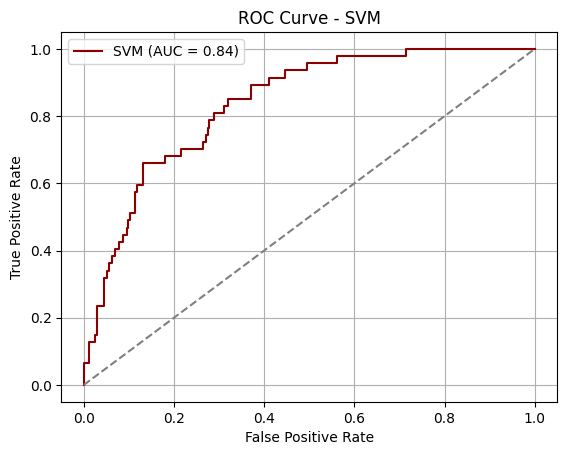

In [17]:
# 12. ROC Curve & AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkred', label='SVM (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve - SVM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

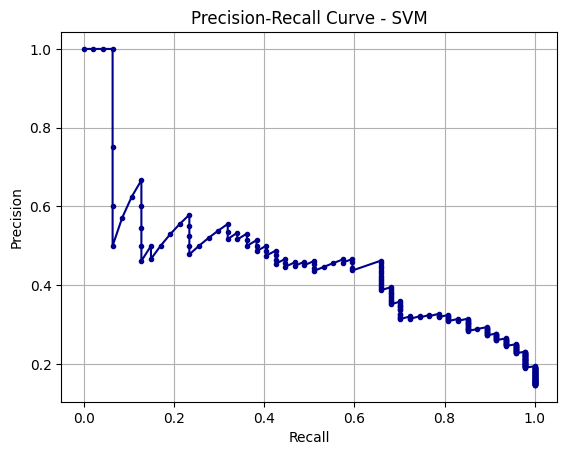

In [18]:
# 13. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.plot(recall, precision, marker='.', color='darkblue')
plt.title('Precision-Recall Curve - SVM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

In [19]:
# 14. Log Loss
logloss = log_loss(y_test, y_prob)
print("Log Loss (SVM):", round(logloss, 4))


Log Loss (SVM): 0.3552


/tmp/ipython-input-24-1085300489.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pred_counts.index, y=pred_counts.values, palette='pastel', ax=axes[0])
/tmp/ipython-input-24-1085300489.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=status_counts.index, y=status_counts.values, palette='Set2', ax=axes[1])


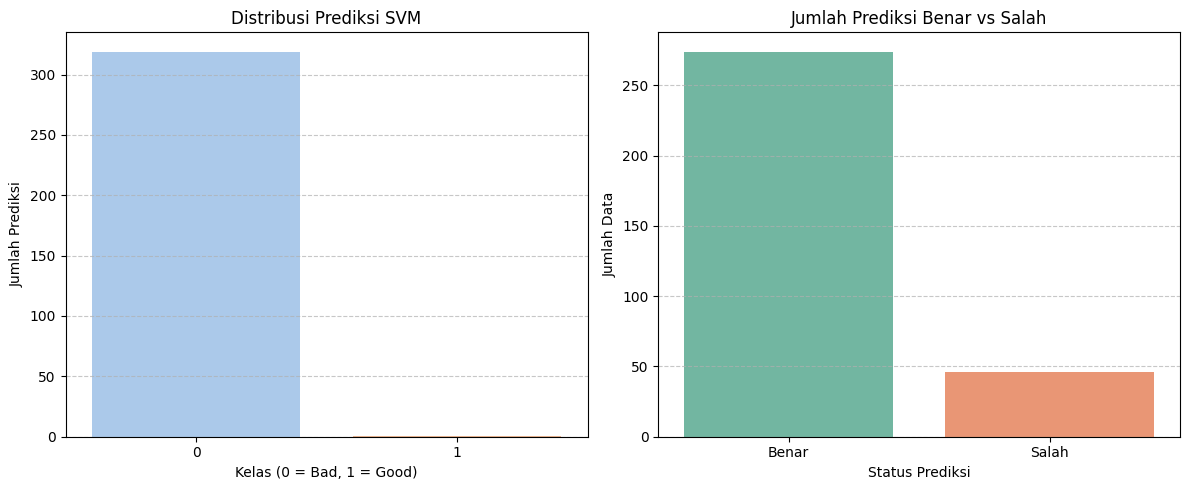

In [24]:
# Visualisasi Distribusi Kelas Prediksi dan Evaluasi Akurasi Model SVM
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Import pandas to create DataFrame

# --- Pastikan sudah ada variabel `y_test` dan `y_pred` ---

# Create the 'hasil' DataFrame
hasil = pd.DataFrame({'Fakta': y_test.values, 'Prediksi': y_pred})

# Tambahkan kolom Status
hasil['Status'] = ['Benar' if f == p else 'Salah'
                   for f, p in zip(hasil['Fakta'], hasil['Prediksi'])]

# Hitung jumlah distribusi prediksi dan status
pred_counts = pd.Series(y_pred).value_counts().sort_index()  # Untuk grafik 1
status_counts = hasil['Status'].value_counts()               # Untuk grafik 2

# --- Mulai Visualisasi ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Grafik 1: Distribusi Prediksi
sns.barplot(x=pred_counts.index, y=pred_counts.values, palette='pastel', ax=axes[0])
axes[0].set_title('Distribusi Prediksi SVM')
axes[0].set_xlabel('Kelas (0 = Bad, 1 = Good)')
axes[0].set_ylabel('Jumlah Prediksi')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Grafik 2: Prediksi Benar vs Salah
sns.barplot(x=status_counts.index, y=status_counts.values, palette='Set2', ax=axes[1])
axes[1].set_title('Jumlah Prediksi Benar vs Salah')
axes[1].set_xlabel('Status Prediksi')
axes[1].set_ylabel('Jumlah Data')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [25]:
# 16. Simpan Sample Output Prediksi
hasil = pd.DataFrame({'Fakta': y_test.values, 'Prediksi': y_pred})
print("\n Contoh Data Prediksi vs Fakta:")
print(hasil.sample(10))


 Contoh Data Prediksi vs Fakta:
     Fakta  Prediksi
201      0         0
310      0         0
282      0         0
274      0         0
250      0         0
215      1         0
89       0         0
26       1         0
234      0         0
38       0         0
